In [ ]:
!pip install catboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


FORECASTING HIDRELÉTRICO - ENSEMBLE (LGB+XGB+CAT)

[1/5] Feature Engineering...
Features criadas: 50 colunas

[2/5] Split Train/Test...
Train: 1139 | Test: 285

[3/5] Treinando Ensemble...

TREINANDO ENSEMBLE DE MODELOS

[1/3] Treinando LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 49.3814	valid's rmse: 103.703
Early stopping, best iteration is:
[61]	train's rmse: 66.7628	valid's rmse: 102.771

[2/3] Treinando XGBoost...
[0]	train-rmse:352.07059	valid-rmse:356.92100
[100]	train-rmse:40.10917	valid-rmse:100.80887
[129]	train-rmse:32.82072	valid-rmse:101.08984

[3/3] Treinando CatBoost...
0:	learn: 353.2576045	test: 358.3182711	best: 358.3182711 (0)	total: 70.8ms	remaining: 1m 10s
100:	learn: 90.0205827	test: 100.8682586	best: 100.8682586 (100)	total: 3.11s	remaining: 27.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 100.6663963
bestIteration = 112

Shrink model to first 113 iterations.

✓ Ensemble treinado com sucesso!

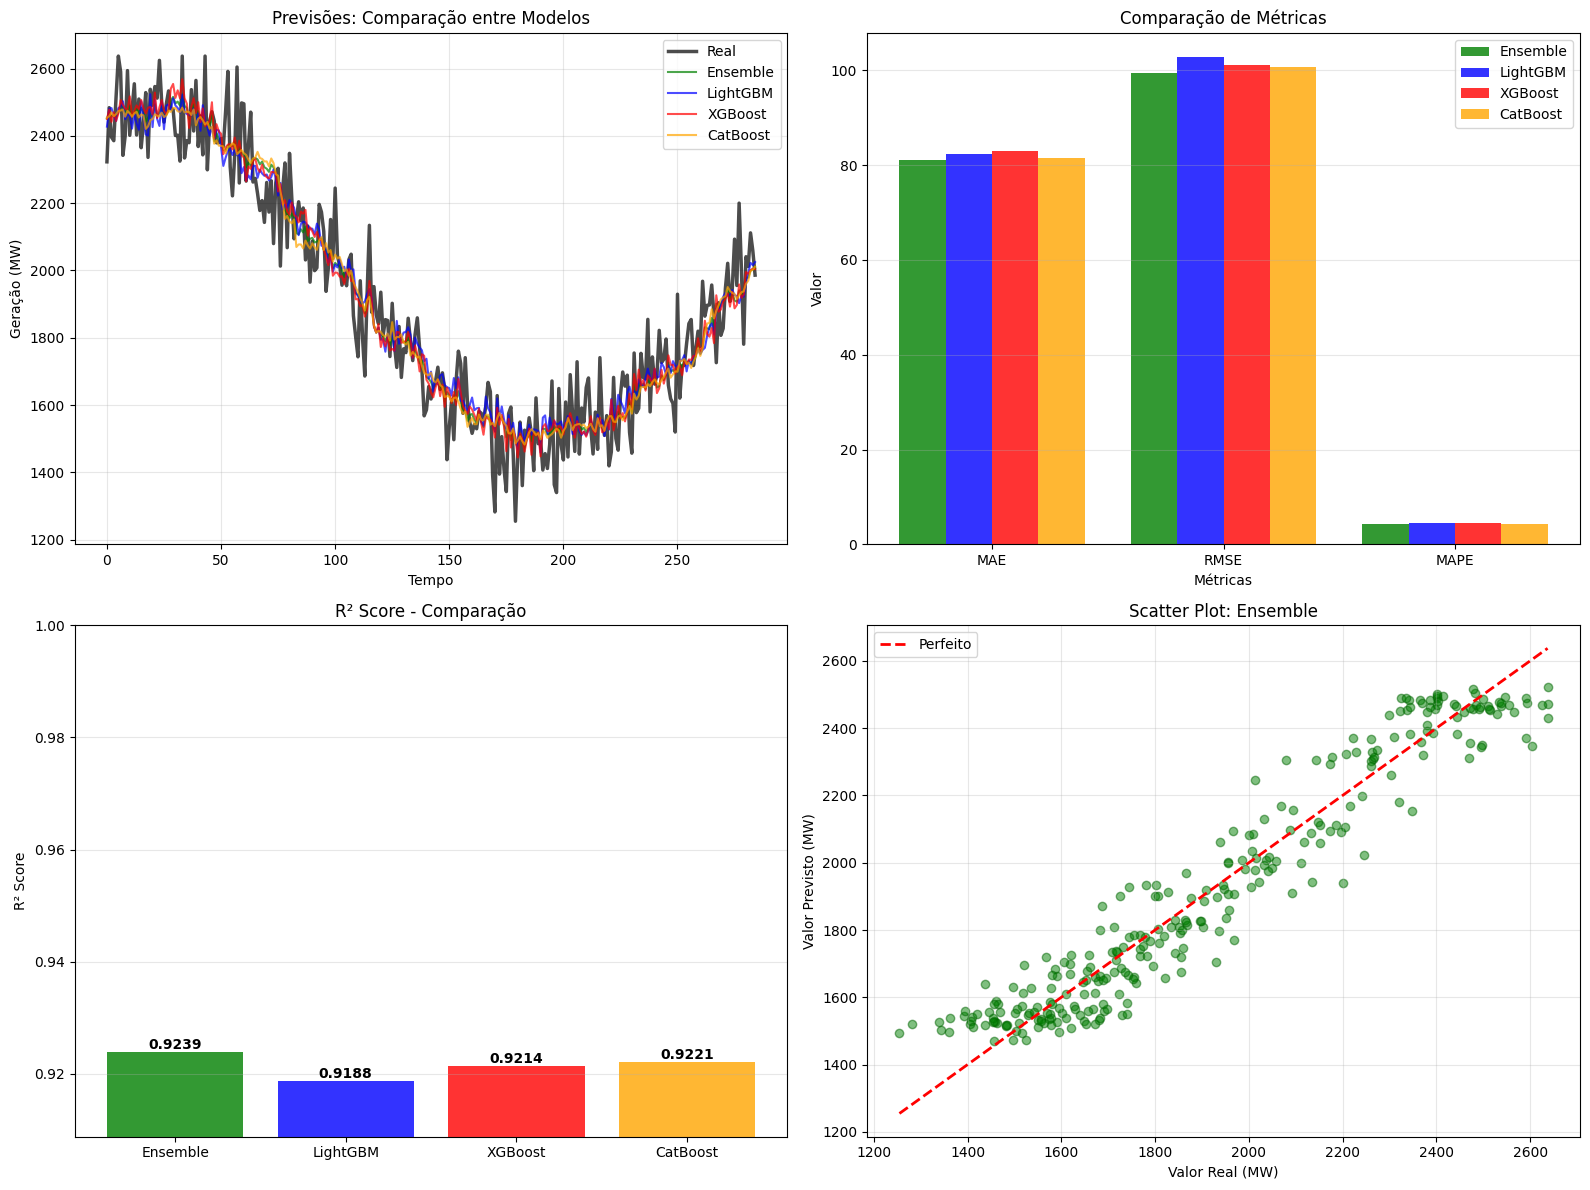

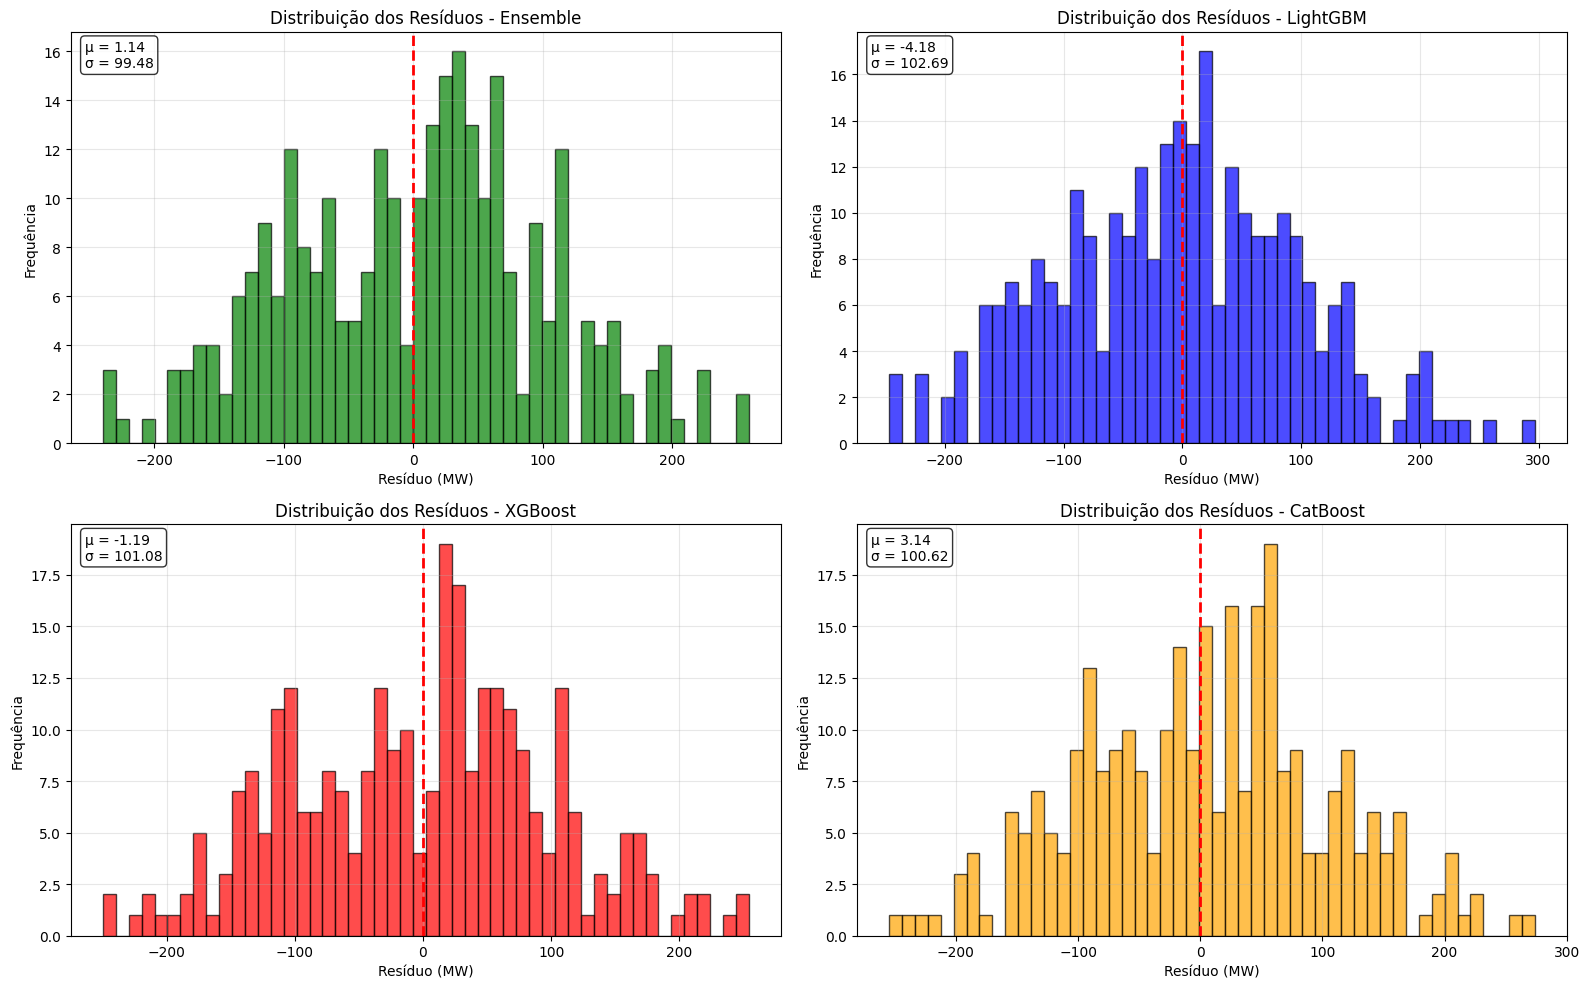


Análise SHAP...

ANÁLISE SHAP - ENSEMBLE

[1/3] Calculando SHAP para LightGBM...
[2/3] Calculando SHAP para XGBoost...
[3/3] Calculando SHAP para CatBoost...


/tmp/ipython-input-3336085183.py:516: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ensemble, X_test, max_display=max_display, show=False)
/tmp/ipython-input-3336085183.py:521: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lgb, X_test, max_display=max_display, show=False)
/tmp/ipython-input-3336085183.py:526: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test, 

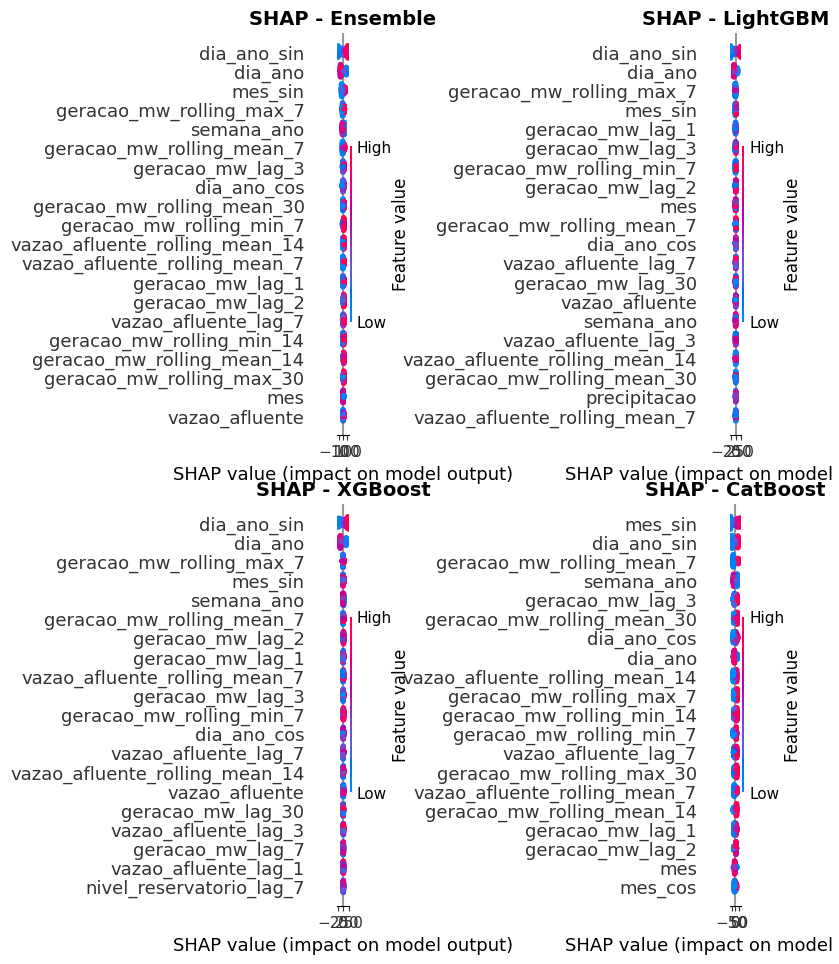

/tmp/ipython-input-3336085183.py:544: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test, plot_type="bar", max_display=15, show=False)
/tmp/ipython-input-3336085183.py:544: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test, plot_type="bar", max_display=15, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/tmp/ipython-input-3336085183.py:544: FutureWarning: The NumPy global RNG was seeded by calli

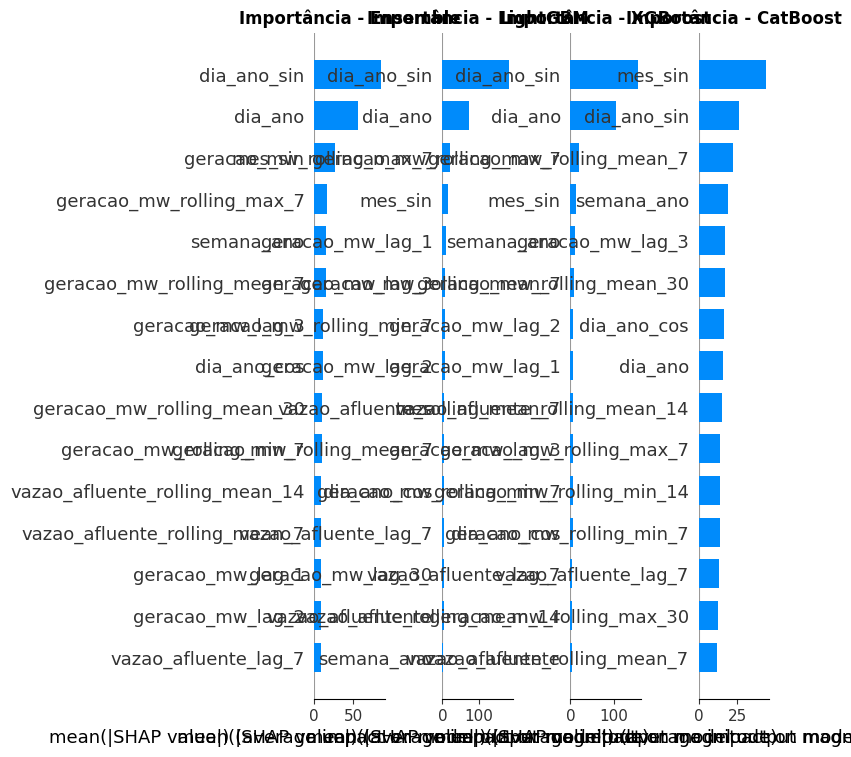


✓ Modelos salvos!

PIPELINE CONCLUÍDO COM SUCESSO!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import shap

# ==========================================
# 1. FEATURE ENGINEERING
# ==========================================

def create_time_features(df, date_col='data'):
    """
    Cria features temporais a partir da data
    """
    df = df.copy()
    df['dia_semana'] = df[date_col].dt.dayofweek
    df['dia_mes'] = df[date_col].dt.day
    df['mes'] = df[date_col].dt.month
    df['trimestre'] = df[date_col].dt.quarter
    df['dia_ano'] = df[date_col].dt.dayofyear
    df['semana_ano'] = df[date_col].dt.isocalendar().week
    df['fim_semana'] = (df['dia_semana'] >= 5).astype(int)

    # Features cíclicas (importante para capturar sazonalidade)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['dia_ano_sin'] = np.sin(2 * np.pi * df['dia_ano'] / 365)
    df['dia_ano_cos'] = np.cos(2 * np.pi * df['dia_ano'] / 365)

    return df


def create_lag_features(df, target_col='geracao_mw', lags=[1, 2, 3, 7, 14, 30]):
    """
    Cria features de lag (valores passados)
    """
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df


def create_rolling_features(df, target_col='geracao_mw', windows=[7, 14, 30]):
    """
    Cria features de médias móveis e estatísticas
    """
    df = df.copy()
    for window in windows:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    return df


def create_external_features(df, feature_cols):
    """
    Cria lags e rolling para variáveis externas (vazão, precipitação, etc)
    """
    df = df.copy()
    for col in feature_cols:
        # Lags para variáveis externas
        for lag in [1, 3, 7]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

        # Rolling para variáveis externas
        for window in [7, 14]:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()

    return df


def prepare_features(df, target_col='geracao_mw',
                    external_cols=['vazao_afluente', 'precipitacao', 'nivel_reservatorio'],
                    forecast_horizon=7):
    """
    Pipeline completo de feature engineering
    """
    df = df.copy()

    # Features temporais
    df = create_time_features(df)

    # Lags do target
    df = create_lag_features(df, target_col)

    # Rolling statistics
    df = create_rolling_features(df, target_col)

    # Features de variáveis externas
    if external_cols:
        df = create_external_features(df, external_cols)

    # Criar target para forecast_horizon dias à frente
    df[f'{target_col}_target'] = df[target_col].shift(-forecast_horizon)

    # Remover NaN criados pelos lags e rolling
    df = df.dropna()

    return df


# ==========================================
# 2. PREPARAÇÃO DOS DADOS
# ==========================================

def split_train_test(df, target_col='geracao_mw_target', test_size=0.2):
    """
    Split temporal dos dados
    """
    # Identificar features (todas exceto target e data)
    feature_cols = [col for col in df.columns if col not in [target_col, 'data', 'geracao_mw']]

    X = df[feature_cols]
    y = df[target_col]

    # Split temporal
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test, feature_cols


# ==========================================
# 3. MODELOS INDIVIDUAIS
# ==========================================

def train_lightgbm(X_train, y_train, X_val, y_val, params=None):
    """
    Treina modelo LightGBM
    """
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'max_depth': -1,
            'min_child_samples': 20,
            'verbose': -1
        }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    return model


def train_xgboost(X_train, y_train, X_val, y_val, params=None):
    """
    Treina modelo XGBoost
    """
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': 0.05,
            'max_depth': 6,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'hist',
            'verbosity': 0
        }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    evals = [(dtrain, 'train'), (dval, 'valid')]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=100
    )

    return model


def train_catboost(X_train, y_train, X_val, y_val, params=None):
    """
    Treina modelo CatBoost
    """
    if params is None:
        params = {
            'iterations': 1000,
            'learning_rate': 0.05,
            'depth': 6,
            'l2_leaf_reg': 3,
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'early_stopping_rounds': 50,
            'verbose': 100,
            'random_seed': 42
        }

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, verbose=100)

    return model


# ==========================================
# 4. ENSEMBLE DE MODELOS
# ==========================================

class EnsembleModel:
    """
    Ensemble combinando LightGBM, XGBoost e CatBoost
    """

    def __init__(self, weights=None):
        """
        Args:
            weights: pesos para cada modelo [lgb, xgb, cat]
                    Se None, usa média simples
        """
        self.lgb_model = None
        self.xgb_model = None
        self.cat_model = None
        self.weights = weights if weights else [1/3, 1/3, 1/3]

    def train(self, X_train, y_train, X_val, y_val):
        """
        Treina os três modelos
        """
        print("\n" + "="*60)
        print("TREINANDO ENSEMBLE DE MODELOS")
        print("="*60)

        # LightGBM
        print("\n[1/3] Treinando LightGBM...")
        self.lgb_model = train_lightgbm(X_train, y_train, X_val, y_val)

        # XGBoost
        print("\n[2/3] Treinando XGBoost...")
        self.xgb_model = train_xgboost(X_train, y_train, X_val, y_val)

        # CatBoost
        print("\n[3/3] Treinando CatBoost...")
        self.cat_model = train_catboost(X_train, y_train, X_val, y_val)

        print("\n✓ Ensemble treinado com sucesso!")

    def predict(self, X):
        """
        Predição usando ensemble ponderado
        """
        # Predições individuais
        pred_lgb = self.lgb_model.predict(X, num_iteration=self.lgb_model.best_iteration)

        if isinstance(X, pd.DataFrame):
            pred_xgb = self.xgb_model.predict(xgb.DMatrix(X))
        else:
            pred_xgb = self.xgb_model.predict(xgb.DMatrix(X))

        pred_cat = self.cat_model.predict(X)

        # Ensemble ponderado
        ensemble_pred = (self.weights[0] * pred_lgb +
                        self.weights[1] * pred_xgb +
                        self.weights[2] * pred_cat)

        return ensemble_pred, pred_lgb, pred_xgb, pred_cat

    def optimize_weights(self, X_val, y_val):
        """
        Otimiza pesos do ensemble usando validação
        """
        from scipy.optimize import minimize

        def objective(weights):
            pred, pred_lgb, pred_xgb, pred_cat = self.predict_with_weights(X_val, weights)
            return mean_squared_error(y_val, pred)

        # Restrições: pesos somam 1 e são positivos
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1)] * 3

        result = minimize(objective,
                         x0=self.weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)

        self.weights = result.x
        print(f"\nPesos otimizados: LGB={self.weights[0]:.3f}, XGB={self.weights[1]:.3f}, CAT={self.weights[2]:.3f}")

    def predict_with_weights(self, X, weights):
        """
        Predição com pesos específicos
        """
        pred_lgb = self.lgb_model.predict(X, num_iteration=self.lgb_model.best_iteration)
        pred_xgb = self.xgb_model.predict(xgb.DMatrix(X))
        pred_cat = self.cat_model.predict(X)

        ensemble_pred = (weights[0] * pred_lgb +
                        weights[1] * pred_xgb +
                        weights[2] * pred_cat)

        return ensemble_pred, pred_lgb, pred_xgb, pred_cat


# ==========================================
# 5. AVALIAÇÃO COMPLETA
# ==========================================

def evaluate_ensemble(ensemble, X_test, y_test):
    """
    Avalia ensemble e modelos individuais
    """
    print("\n" + "="*60)
    print("AVALIAÇÃO DO ENSEMBLE")
    print("="*60)

    # Predições
    pred_ensemble, pred_lgb, pred_xgb, pred_cat = ensemble.predict(X_test)

    results = {}

    # Avaliar cada modelo
    for name, pred in [('Ensemble', pred_ensemble),
                       ('LightGBM', pred_lgb),
                       ('XGBoost', pred_xgb),
                       ('CatBoost', pred_cat)]:
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)
        mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

        results[name] = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'predictions': pred
        }

        print(f"\n{name}:")
        print(f"  MAE:  {mae:.2f} MW")
        print(f"  RMSE: {rmse:.2f} MW")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")

    return results


def plot_ensemble_comparison(y_test, results):
    """
    Compara performance dos modelos
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models = ['Ensemble', 'LightGBM', 'XGBoost', 'CatBoost']
    colors = ['green', 'blue', 'red', 'orange']

    # Plot 1: Séries temporais
    ax = axes[0, 0]
    ax.plot(y_test.values, label='Real', linewidth=2.5, color='black', alpha=0.7)
    for model, color in zip(models, colors):
        ax.plot(results[model]['predictions'], label=model,
               linewidth=1.5, alpha=0.7, color=color)
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Geração (MW)')
    ax.set_title('Previsões: Comparação entre Modelos')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Métricas comparativas (barras)
    ax = axes[0, 1]
    metrics_names = ['MAE', 'RMSE', 'MAPE']
    x = np.arange(len(metrics_names))
    width = 0.2

    for i, model in enumerate(models):
        values = [results[model]['mae'],
                 results[model]['rmse'],
                 results[model]['mape']]
        ax.bar(x + i*width, values, width, label=model, color=colors[i], alpha=0.8)

    ax.set_xlabel('Métricas')
    ax.set_ylabel('Valor')
    ax.set_title('Comparação de Métricas')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 3: R² Score
    ax = axes[1, 0]
    r2_scores = [results[model]['r2'] for model in models]
    bars = ax.bar(models, r2_scores, color=colors, alpha=0.8)
    ax.set_ylabel('R² Score')
    ax.set_title('R² Score - Comparação')
    ax.set_ylim([min(r2_scores) - 0.01, 1.0])
    ax.grid(True, alpha=0.3, axis='y')

    # Adicionar valores nas barras
    for bar, score in zip(bars, r2_scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

    # Plot 4: Scatter do Ensemble
    ax = axes[1, 1]
    ax.scatter(y_test, results['Ensemble']['predictions'],
              alpha=0.5, color='green', edgecolors='darkgreen')
    ax.plot([y_test.min(), y_test.max()],
           [y_test.min(), y_test.max()],
           'r--', linewidth=2, label='Perfeito')
    ax.set_xlabel('Valor Real (MW)')
    ax.set_ylabel('Valor Previsto (MW)')
    ax.set_title('Scatter Plot: Ensemble')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_residuals_comparison(y_test, results):
    """
    Compara resíduos dos modelos
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    models = ['Ensemble', 'LightGBM', 'XGBoost', 'CatBoost']
    colors = ['green', 'blue', 'red', 'orange']

    for ax, model, color in zip(axes.ravel(), models, colors):
        residuals = y_test.values - results[model]['predictions']

        ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color=color)
        ax.axvline(0, color='red', linestyle='--', linewidth=2)
        ax.set_xlabel('Resíduo (MW)')
        ax.set_ylabel('Frequência')
        ax.set_title(f'Distribuição dos Resíduos - {model}')
        ax.grid(True, alpha=0.3)

        # Adicionar estatísticas
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        ax.text(0.02, 0.98, f'μ = {mean_res:.2f}\nσ = {std_res:.2f}',
               transform=ax.transAxes, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


# ==========================================
# 6. ANÁLISE SHAP DO ENSEMBLE
# ==========================================

def analyze_shap_ensemble(ensemble, X_train, X_test, feature_names, max_display=20):
    """
    Análise SHAP para os 3 modelos do ensemble
    """
    print("\n" + "="*60)
    print("ANÁLISE SHAP - ENSEMBLE")
    print("="*60)

    # SHAP para LightGBM
    print("\n[1/3] Calculando SHAP para LightGBM...")
    explainer_lgb = shap.TreeExplainer(ensemble.lgb_model)
    shap_values_lgb = explainer_lgb.shap_values(X_test)

    # SHAP para XGBoost
    print("[2/3] Calculando SHAP para XGBoost...")
    explainer_xgb = shap.TreeExplainer(ensemble.xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_test)

    # SHAP para CatBoost
    print("[3/3] Calculando SHAP para CatBoost...")
    explainer_cat = shap.TreeExplainer(ensemble.cat_model)
    shap_values_cat = explainer_cat.shap_values(X_test)

    # SHAP do Ensemble (média ponderada)
    shap_values_ensemble = (ensemble.weights[0] * shap_values_lgb +
                           ensemble.weights[1] * shap_values_xgb +
                           ensemble.weights[2] * shap_values_cat)

    # Plot comparativo de importância
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Ensemble
    plt.sca(axes[0, 0])
    shap.summary_plot(shap_values_ensemble, X_test, max_display=max_display, show=False)
    axes[0, 0].set_title('SHAP - Ensemble', fontsize=14, fontweight='bold')

    # LightGBM
    plt.sca(axes[0, 1])
    shap.summary_plot(shap_values_lgb, X_test, max_display=max_display, show=False)
    axes[0, 1].set_title('SHAP - LightGBM', fontsize=14, fontweight='bold')

    # XGBoost
    plt.sca(axes[1, 0])
    shap.summary_plot(shap_values_xgb, X_test, max_display=max_display, show=False)
    axes[1, 0].set_title('SHAP - XGBoost', fontsize=14, fontweight='bold')

    # CatBoost
    plt.sca(axes[1, 1])
    shap.summary_plot(shap_values_cat, X_test, max_display=max_display, show=False)
    axes[1, 1].set_title('SHAP - CatBoost', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Bar plot comparativo
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))

    for ax, shap_vals, title in zip(axes,
                                     [shap_values_ensemble, shap_values_lgb, shap_values_xgb, shap_values_cat],
                                     ['Ensemble', 'LightGBM', 'XGBoost', 'CatBoost']):
        plt.sca(ax)
        shap.summary_plot(shap_vals, X_test, plot_type="bar", max_display=15, show=False)
        ax.set_title(f'Importância - {title}', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return shap_values_ensemble, explainer_lgb


# ==========================================
# 7. EXEMPLO DE USO COMPLETO
# ==========================================

def exemplo_completo():
    """
    Pipeline completo com Ensemble
    """
    print("="*60)
    print("FORECASTING HIDRELÉTRICO - ENSEMBLE (LGB+XGB+CAT)")
    print("="*60)

    # Simular dados
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    df = pd.DataFrame({
        'data': dates,
        'geracao_mw': np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 500 + 2000 + np.random.randn(len(dates)) * 100,
        'vazao_afluente': np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 50 + 300 + np.random.randn(len(dates)) * 20,
        'precipitacao': np.maximum(0, np.random.randn(len(dates)) * 10 + 50),
        'nivel_reservatorio': 100 + np.random.randn(len(dates)) * 2
    })

    FORECAST_HORIZON = 7

    # Feature Engineering
    print("\n[1/5] Feature Engineering...")
    df_features = prepare_features(df, forecast_horizon=FORECAST_HORIZON)
    print(f"Features criadas: {df_features.shape[1]} colunas")

    # Split
    print("\n[2/5] Split Train/Test...")
    X_train, X_test, y_train, y_test, feature_cols = split_train_test(df_features)
    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

    # Treinar Ensemble
    print("\n[3/5] Treinando Ensemble...")
    ensemble = EnsembleModel()
    ensemble.train(X_train, y_train, X_test, y_test)

    # Otimizar pesos (opcional)
    print("\n[4/5] Otimizando pesos do Ensemble...")
    ensemble.optimize_weights(X_test, y_test)

    # Avaliar
    print("\n[5/5] Avaliação...")
    results = evaluate_ensemble(ensemble, X_test, y_test)

    # Visualizações
    print("\nGerando visualizações...")
    plot_ensemble_comparison(y_test, results)
    plot_residuals_comparison(y_test, results)

    # SHAP
    print("\nAnálise SHAP...")
    shap_values, explainer = analyze_shap_ensemble(ensemble, X_train, X_test, feature_cols)

    # Salvar modelos
    ensemble.lgb_model.save_model('ensemble_lightgbm.txt')
    ensemble.xgb_model.save_model('ensemble_xgboost.json')
    ensemble.cat_model.save_model('ensemble_catboost.cbm')
    print("\n✓ Modelos salvos!")

    print("\n" + "="*60)
    print("PIPELINE CONCLUÍDO COM SUCESSO!")
    print("="*60)

    return ensemble, df_features, results


if __name__ == "__main__":
    ensemble, df, results = exemplo_completo()